In [1]:
import sys
sys.path.append("../../")

import numpy as np
from scipy.signal import find_peaks
import math
from typing import List
import logging

from didgelab.calc.conv import *
from didgelab.evo.nuevolution import GeoGenome, LossFunction
from didgelab.calc.geo import Geo
from didgelab.calc.sim.sim import get_log_simulation_frequencies, create_segments, compute_impedance, compute_ground_spektrum
from didgelab.calc.sim.sim import create_segments, compute_impedance, get_notes


In [2]:
import os
import json

da_path = "../../../../didge-archive"
da = json.load(open(os.path.join(da_path, "didge-archive.json")))

didge = da[5]
wav_file = os.path.join(da_path, didge["audio-samples"]["song"])
print(json.dumps(didge, indent=4))


{
    "name": "Open Didgeridoo Straight",
    "audio-samples": {
        "neutral-sound": "audio-samples/opendidge-2-straight-short.wav",
        "song": "audio-samples/opendidge-2-straight-long.wav"
    },
    "geometry": "geometries/opendidgeridoo.json",
    "shape": "straight",
    "license": "[Open Didgeridoo License](https://www.windproject.it/open-didgeridoo/)"
}


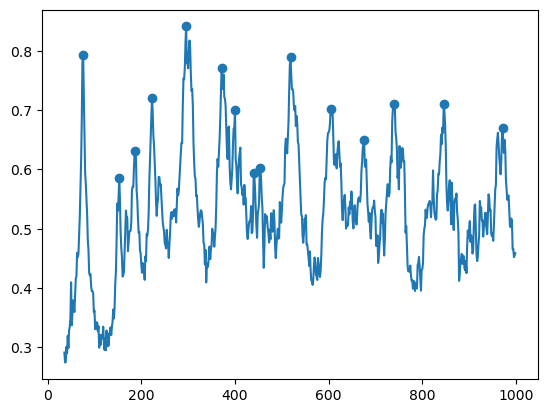

In [137]:
import scipy
import matplotlib.pyplot as plt

def minmax(x):
    x-=x.min()
    x/=x.max()
    return x

# compute fft for window
def fft_for_window(signal, sampFreq, minfreq=35, maxfreq=1000):
    fft_spectrum = np.fft.rfft(signal, n=len(signal))
    freq = np.fft.rfftfreq(len(signal), d=1./sampFreq)

    fft_spectrum = fft_spectrum[(freq>minfreq) & (freq<maxfreq)]
    fft_spectrum = np.log2(np.abs(fft_spectrum))
    freq = freq[(freq>minfreq) & (freq<maxfreq)]

    # minmax normalization
    fft_spectrum = minmax(fft_spectrum)
    return freq, fft_spectrum

# compute the fundamental frequency from an fftp
def get_fundamental(fft_freq, fft, minfreq=50, maxfreq=120):
    freqs = fft_freq[(fft_freq>minfreq) & (fft_freq<maxfreq)]
    _fft = fft[(fft_freq>minfreq) & (fft_freq<maxfreq)]
    max_freq = freqs[np.argmax(_fft)]
    return max_freq


def filter_list(l, i):
    result = []
    for j in range(len(i)):
        if i[j]:
            result.append(l[j])
    return result

def compute_mean_spectrum(wav_file):
    # read signal
    sampFreq, signal = scipy.io.wavfile.read(wav_file)

    # when stereo, use just one channel
    if len(signal.shape)==2:
        signal = signal[:,0]
    else:
        signal = signal

    # split signal in windows of 1s 
    window_size = int(sampFreq*0.7)
    windows = np.array([signal[i-window_size:i] for i in np.arange(window_size, len(signal), window_size)])

    ffts = [fft_for_window(signal, sampFreq) for signal in windows]
    fundamentals = [get_fundamental(freqs, spectrum) for freqs, spectrum in ffts]

    # remove outliers in which the fundamental differs more than 5% from the mean
    mean_fundamental = np.mean(fundamentals)
    deltas = np.abs(fundamentals - mean_fundamental)
    i = deltas<0.05 * mean_fundamental
    ffts = filter_list(ffts, i)
    fundamentals = filter_list(fundamentals, i)

    # calculate mean spectrum and its resonant peaks
    freqs = ffts[0][0]
    mean_spectrum = np.mean([fft[1] for fft in ffts], axis=0)

    return freqs, mean_spectrum

def compute_peaks(freqs, mean_spectrum):
    peaks = scipy.signal.find_peaks(mean_spectrum, prominence=0.1)[0]
    peak_f = freqs[peaks]
    peak_amp = mean_spectrum[peaks]
    return peak_f, peak_amp

didge = da[5]
wav_file = os.path.join(da_path, didge["audio-samples"]["song"])

freqs, mean_spectrum = compute_mean_spectrum(wav_file)
peak_f, peak_amp = compute_peaks(freqs, mean_spectrum)

plt.plot(freqs, mean_spectrum)
plt.scatter(peak_f, peak_amp)
#plt.plot(results[i]["fft_freq"], results[i]["fft_spectrum"], color="blue")
#plt.scatter(results[i]["peak_f"], results[i]["peak_amp"], color="green")


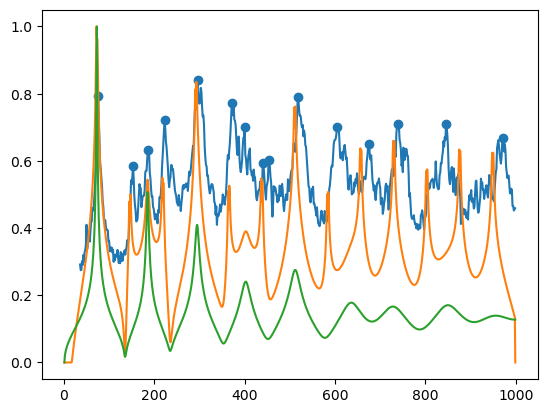

In [152]:
freqs, mean_spectrum = compute_mean_spectrum(wav_file)
peak_f, peak_amp = compute_peaks(freqs, mean_spectrum)

geo = os.path.join(da_path, didge["geometry"])
geo =json.load(open(geo))
geo = Geo(geo)
segments = create_segments(geo)
imp_freqs = np.arange(1, 1000)
impedances = compute_impedance(segments, imp_freqs)
ground = compute_ground_spektrum(imp_freqs, impedances)

ground = minmax(ground)
impedances = minmax(impedances)

plt.plot(freqs, mean_spectrum)
plt.scatter(peak_f, peak_amp)
plt.plot(imp_freqs, ground)
plt.plot(imp_freqs, np.sqrt(impedances))

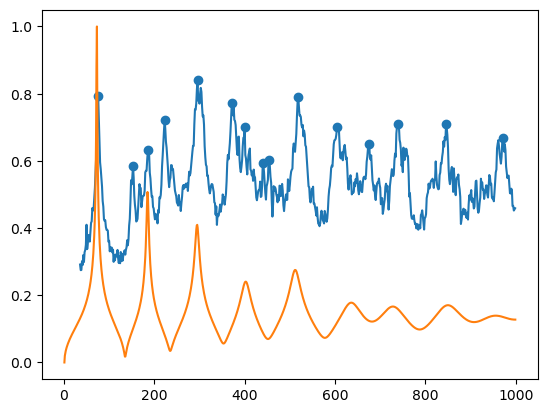

In [ ]:
ground = []
window_size = 1.5*peak_f[0]

plt.plot(freqs, mean_spectrum)
plt.scatter(peak_f, peak_amp)
#plt.plot(imp_freqs, ground)
plt.plot(imp_freqs, np.sqrt(impedances))

/var/folders/4j/t75nkw0d3ns8555qlllkhm6h0000gn/T/ipykernel_34500/659963451.py:9: RuntimeWarning: divide by zero encountered in divide
  _y = amp/np.abs(x-f)


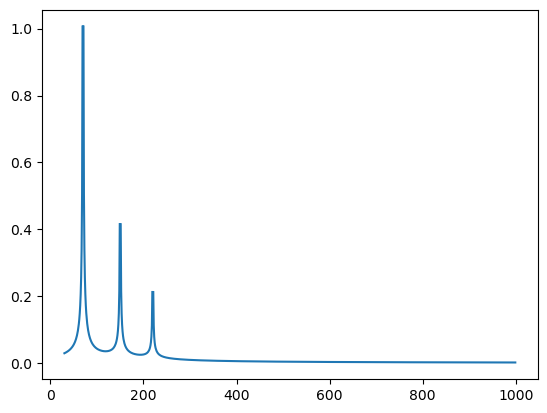

In [ ]:


peak_f = np.array([70, 150, 220])
peak_amp = np.array([1, 0.4, 0.2])

x = np.arange(30, 1000)
y = np.zeros(len(x))

for f, amp in zip(peak_f, peak_amp):

    _y = amp/np.abs(x-f)
    y += _y

plt.plot(x,y)

